In [1]:
import numpy as np
from scipy.special import logit, expit
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import seaborn as sns

from PIL import Image
import torch
from pathlib import Path
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from skimage.transform import resize
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve, auc
from tqdm.notebook import tqdm
from datetime import datetime
seed=42
np.random.seed(seed)
torch.manual_seed(seed)

class TOPDataset(Dataset):
  def __init__(self, csv_file, img_dir, targets, transform=None,
               covariates=None, return_covariates='auto', 
               labelsmoothing_alpha=0, include_third_channel=False, filter_label=None):
    self.csv_file = csv_file
    self.img_dir = Path(img_dir)
    self.transforms = transforms.ToTensor() if transform is None else transform
    self.targets = targets if not isinstance(targets, str) else [targets]
    self.covariates = covariates if not isinstance(covariates, str) else [covariates]
    self.return_covariates = (covariates is not None) if return_covariates=='auto' else return_covariates
    self.labelsmoothing_alpha = labelsmoothing_alpha
    self.include_third_channel = include_third_channel
    self.df = pd.read_csv(csv_file)
    if filter_label is not None:
      print(f'Caution: This dataloader will be filtered to only include images with this label: {filter_label}')
      self.df = self.df[self.df[filter_label]==1]
    
  def __len__(self):
    return self.df.filename.size
  
  def __getitem__(self, idx):
    row = self.df.iloc[idx,:]
    
    image = Image.open(self.img_dir/row['filename'])
    # all images are loaded as left eyes by default, i.e. right eyes are flipped
    if row['LR'] == 'R':
      image=image.transpose(Image.FLIP_LEFT_RIGHT)
    image = self.transforms(image)
    if not self.include_third_channel:
      image=image[:2,...]
      
    targets = torch.Tensor(row[self.targets])
    
    if self.labelsmoothing_alpha > 0:
      targets *= (1-(self.labelsmoothing_alpha*2))
      targets += self.labelsmoothing_alpha
    
    if self.return_covariates:
      if self.covariates is not None:
        covariates = row[self.covariates].values[0]
      else:
        covariates = None
      return image, targets, covariates
    
    return image, targets

# TOP Train set, exact
## Adding a third value for compatability with plotting images
norm_means = [0.22578795, 0.23797078, 1]
norm_stds = [0.14651306, 0.11282759, 1]
resolution = (384, 512)

basic_transform_with_resize = transforms.Compose([
                                      transforms.ToTensor(),
    transforms.Resize((384,512)),                                  
    transforms.Normalize(norm_means, norm_stds)])
denormalize = transforms.Compose([transforms.Normalize(-np.array(norm_means)/np.array(norm_stds),
                                                       1/np.array(norm_stds))])
denormalize_2ch = transforms.Compose([transforms.Normalize(-np.array(norm_means[:2])/np.array(norm_stds[:2]),
                                                       1/np.array(norm_stds[:2]))])

targets = ['MH', 'RP', 'AMD', 'RVO', 'RD', 'Gla', 'DR', 'any_retina_disease']


model = torch.load('PATH/TO/MODEL/ema_model.pt')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print()

In [2]:
def tensor_to_img(img):
  img = denormalize_2ch(img).numpy().transpose(1,2,0)
  img = np.dstack([img, np.zeros(img.shape[:-1])])
  return img

def plot_2channel_img(img):
  plt.figure(dpi=150)
  plt.imshow(tensor_to_img(img))
  
def sigmoid(arr):
  arr = torch.Tensor(arr)
  arr = torch.sigmoid(arr)
  arr = arr.numpy()
  return arr

def make_gradcam_heatmap(img, model, 
                         class_idx=None, block=7,
                         interpolation_mode='nearest', norm='max1',
                         device='cpu'):
  data_transform = transforms.Compose([transforms.ToTensor(),
                                       # Careful, this uses global variables
                                       transforms.Normalize(norm_means, norm_stds)])
  data_transform=basic_transform_with_resize
  img = data_transform(img).unsqueeze(0)
  img = img[:,:2,...].float()
  
  model_prepool = nn.Sequential(*list(model.children())[:block+1]).float().to(device)
  model_head = nn.Sequential(*list(model.children())[block+1:]).float().to(device)
  
  prepool_out = model_prepool(img.to(device))
  prediction = model_head[:-1](prepool_out).flatten().unsqueeze(0)
  prediction = model_head[-1](prediction)

  if class_idx is None:
    # by convention, the last label is healthy-unhealthy
    class_idx = torch.argmax(prediction[0,:-1])
  class_channel = prediction[...,class_idx]

  gradients = torch.autograd.grad(class_channel, prepool_out)[0]
  pooled_gradients = torch.mean(gradients, axis=(2,3)).squeeze(0).detach()
  prepool_out = prepool_out.squeeze(0).detach()
  heatmap = torch.zeros(size=(prepool_out.size()[-2:])).to(device)

  for idx, weight in enumerate(pooled_gradients):
    heatmap += prepool_out[idx,...]*weight

  heatmap = heatmap.clamp(0)
  heatmap = heatmap - torch.min(heatmap)
  
  # this does nothing
  if norm=='mass1':
    # norm to mass 1
    heatmap /= (heatmap.sum() + 1e-15)
  elif norm=='max1':
    # norm to max 1
    heatmap /= (heatmap.max() + 1e-15)
#   heatmap = heatmap / (torch.max(heatmap)+1e-12)

  heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), size=img.size()[-2:],
                         mode=interpolation_mode).squeeze(0).squeeze(0).clamp(0)

  return heatmap.to('cpu').numpy(),torch.sigmoid(prediction).detach().to('cpu').numpy()[0]

def plot_gradcam_image(img, model, class_idx=1, block=7, axes=None, heatmap_alpha=0.3,
                       device=None, show=True, dpi=250):
  if axes is None:
    fig, axes = plt.subplots(1,3, dpi=dpi)
    for ax in axes:
      ax.axis('off')
  
  axes[0].imshow(np.array(img))
  heatmap, preds = make_gradcam_heatmap(img=img, model=model,
                                 class_idx=class_idx, block=block,
                                interpolation_mode='nearest', device=device)
  axes[1].imshow(heatmap.clip(0,1), cmap='jet')
  # TODO targets are hardcoded right now
  if class_idx is None:
    class_idx = np.argmax(preds[:-1])
#   print(preds, class_idx)
  axes[1].text(15, 370, '$\hat{p}$'+f'({targets[class_idx][:3]}) = {preds[class_idx]:.4f}',
               {'fontsize':'xx-small','backgroundcolor':'white'}, 
               bbox={'alpha':0.8, 'facecolor':'white', 'edgecolor':'none'})
  
  jet = cm.get_cmap("jet")
  jet_colors = jet(np.arange(256))[:, :3]
  heatmap = np.uint8(255 * heatmap)
  jet_heatmap = jet_colors[heatmap]
  # remove blue
  jet_heatmap[:,:,2]*=0.1
  heatmap_on_img = (jet_heatmap * heatmap_alpha +  (1-heatmap_alpha) * (resize(np.array(img), (384,512))/1))
  axes[2].imshow(heatmap_on_img)
  plt.subplots_adjust(wspace=0.01)
  if show:
    plt.show()

def predict_on_img(model, device=None, image=None, img_path=None,
                   transform=basic_transform_with_resize, image_LR='L',
                   plot_img=False, print_preds=False, plot_grad_cam=False):
  if image is None:
    assert img_path is not None
    image = Image.open(img_path)
  # all images are loaded as left eyes by default, i.e. right eyes are flipped
  if image_LR == 'R':
    image=image.transpose(Image.FLIP_LEFT_RIGHT)
  clean_image = image.copy()

  image = basic_transform_with_resize(image)
  image=image[:2,...]
  
  if device is None:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  image=image.to(device)

  image=image.unsqueeze(0)
  
  with torch.no_grad():
    preds = torch.sigmoid(model(image)).cpu().numpy()[0]
  

  if plot_img:
    plt.imshow(clean_image)
    plt.show()

  
  if plot_grad_cam:
    plot_gradcam_image(clean_image, model, class_idx=-1, block=7, device=device)
    plt.show()
  
  if print_preds:
    pred_label_str = ""
    for i in range(len(targets)):
      pred_label_str+=f'{targets[i][:3]}:'
      pred_label_str+=f'{preds[i]:.3f} '
    print(pred_label_str)
  
  return preds

In [3]:
extset_df = pd.read_csv('PATH/TO/EXTERNALVALSET/external_valset.csv')

for img_idx in tqdm(range(extset_df.shape[0])):
  img_LR = extset_df.LR[img_idx]
  img_label = extset_df.Label[img_idx]
  img_name = extset_df.Filename[img_idx]
  img_path = 'PATH/TO/EXTERNALVALSET/' + img_name

  preds = predict_on_img(model, img_path=img_path, image_LR=img_LR, 
                         # Set this to True to see GradCams
                         # This is set to False here since we cannot share these images
                         plot_grad_cam=False,
                         print_preds=False)
  if img_label=='Healthy':
    extset_df.loc[img_idx,'p(label)'] = 1-preds[-1]
  else:
    # ugly hack
    try:
      img_labelidx = targets.index(img_label)
    except:
      img_labelidx = targets.index('DR')
    extset_df.loc[img_idx,'p(label)'] = preds[img_labelidx]
  extset_df.loc[img_idx, [f'p({t})' for t in targets]] = preds
  extset_df.loc[img_idx, f'max(p(l))'] = np.max(preds[:-1])
  print(f'{img_idx+1:<2}/{extset_df.shape[0]}: {img_name}', end='-')
  print(f'Target label: {img_label}, p(label): {extset_df.loc[img_idx,"p(label)"]:.4f}')
  extset_df.loc[img_idx,'p(any)'] = preds[-1]
  

  0%|          | 0/75 [00:00<?, ?it/s]

1 /75: ASRS-RIB-Image-27209.jpg-Target label: RP, p(label): 0.2770
2 /75: ASRS-RIB-Image-28324.jpg-Target label: RP, p(label): 0.6970
3 /75: ASRS-RIB-Image-18045.jpg-Target label: RP, p(label): 0.8910
4 /75: ASRS-RIB-Image-25606.jpg-Target label: RVO, p(label): 0.6643
5 /75: ASRS-RIB-Image-66298.jpg-Target label: RVO, p(label): 0.9267
6 /75: ASRS-RIB-Image-26484.jpg-Target label: RD, p(label): 0.7363
7 /75: ASRS-RIB-Image-30011.jpg-Target label: RD, p(label): 0.7240
8 /75: Normal HOZ-20190131 (1).jpg-Target label: Healthy, p(label): 0.4211
9 /75: RP DVY-20190416 (1) From SCO.jpg-Target label: RP, p(label): 0.9441
10/75: RP DVY-20190416 (2).jpg-Target label: RP, p(label): 0.9431
11/75: RP GSL1-20190731 (1) 20-30 OU With OCT and Optos with FAF _ LEFTEYE.jpg-Target label: RP, p(label): 0.9192
12/75: RP GSL1-20190731 (1) 20-30 OU With OCT and Optos with FAF _ RIGHTEYE.jpg-Target label: RP, p(label): 0.9417
13/75: RP LYV2-20181121 (5) _ LEFTEYE.jpg-Target label: RP, p(label): 0.9286
14/75: 

In [4]:
auc = roc_auc_score(y_true=extset_df.Label!='Healthy', y_score=extset_df['p(any)'])
print('Healthy vs unhealthy AUC:', np.round(auc,4))

for l in ['DR', 'AMD', 'RP', 'RVO', 'RD',  'Gla']:
  auc = roc_auc_score(y_true=[l in _ for _ in extset_df.Label], 
                      y_score=extset_df[f'p({l})'])
  print(f'{l}: {auc:.4f}', end=', ')

Healthy vs unhealthy AUC: 0.9841
DR: 0.9627, AMD: 0.8051, RP: 1.0000, RVO: 0.9754, RD: 1.0000, Gla: 0.9595, 

In [5]:
extset_df['Label_plot']=[_ if not 'R,A' in _ else 'DR+AMD' for _ in extset_df['Label'].values]
extset_df['Label_plot']=[_ if not '?' in _ else 'DR' for _ in extset_df['Label_plot'].values]
label_n_dict = extset_df['Label_plot'].value_counts().to_dict()
extset_df['Label_plot'] = [f'{_}\n(n={label_n_dict[_]})' for _ in extset_df['Label_plot']]

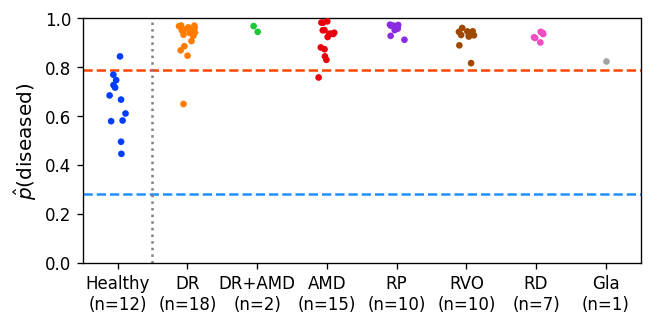

In [6]:
plt.figure(dpi=120)
col_order = [
'Healthy\n(n=12)',
 'DR\n(n=18)',
 'DR+AMD\n(n=2)',
 'AMD\n(n=15)',
  'RP\n(n=10)',
 'RVO\n(n=10)',
 'RD\n(n=7)',
 'Gla\n(n=1)',
]
# setting seed to get a decent looking plot
np.random.seed(47)
sns.stripplot(data=extset_df,y='p(any)', x='Label_plot', size=4, jitter=0.12,
              order=col_order, palette=sns.color_palette('bright'))
plt.axhline(0.79, c='orangered', linestyle='--')
plt.axhline(0.28, c='dodgerblue', linestyle='--')
plt.ylim(0,1)
plt.ylabel('$\hat{p}$(diseased)',fontsize='large')
plt.xlabel(None)
plt.axvline(0.5, linestyle=':', c='gray')
plt.gca().set_aspect(3.5)
plt.show()

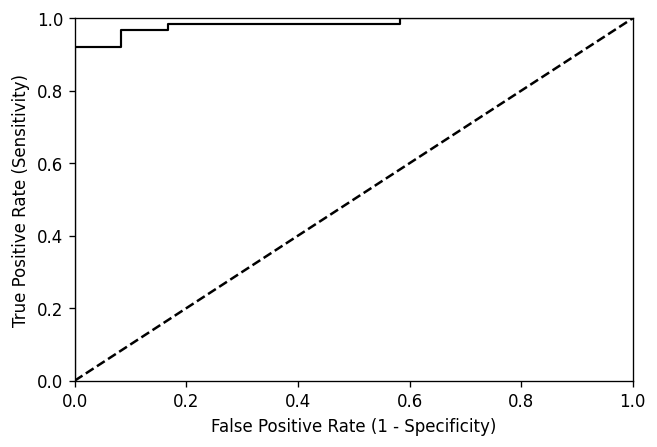

In [7]:
fpr, tpr, thresholds = roc_curve(extset_df.Label.apply(lambda x: 'Healthy' not in x), extset_df['p(any_retina_disease)'])

plt.figure(dpi=120)
plt.plot(fpr, tpr, lw=1.3, c='black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot([0, 1], [0, 1], linestyle='--', c='black')
plt.xlim(0.,1)
plt.ylim(0.,1)
plt.show()